In [1]:
import copy
import h5py
import numpy as np
import os
import pandas as pd
import sys

In [2]:
import analysis_config

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import palettable

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [5]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.astro as astro_tools

In [6]:
import linefinder.utils.file_management as file_management_old
import linefinder.utils.file_management_new as file_management
import linefinder.config as config

# Load Data

### Parameters

In [7]:
# Sim params
default_sim = 'm11d'
default_snum = 600
resolution = 7100
physics = 'metal_diffusion'
subsubdir = None

In [8]:
# Halo file params
mt_kwargs = {
    'tag': 'smooth',
}

In [9]:
# Data selection params
t_window = 1. # In Gyr
galdef = ''
galaxy_cut = 0.1
length_scale = 'Rvir'

### Get Data Structures

In [10]:
if len( sys.argv ) == 2:
    sim_name = sys.argv[1]
else:
    sim_name = default_sim

In [11]:
# Automatically set or retrieve args
if len( sys.argv ) == 3:
    try:
        snum = int( sys.argv[2] )
    except ValueError:
        snum = default_snum
else:
    snum = default_snum

In [12]:
sim_kwargs = dict(
    sim_name = sim_name,
    resolution = resolution,
    physics = physics,
    subsubdir = subsubdir,
)

In [13]:
fm = file_management.FileManager( 'hot_accretion' )
fm_old = file_management_old.FileManager( 'hot_accretion' )

In [14]:
ind = 600 - snum

In [16]:
g_data = particle_data.ParticleData(
    sdir = fm.get_sim_dir( **sim_kwargs ),
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = fm.get_halo_dir( **sim_kwargs, halo_subdir='' ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

In [17]:
s_data = particle_data.ParticleData(
    sdir = fm.get_sim_dir( **sim_kwargs ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = fm.get_halo_dir( **sim_kwargs, halo_subdir='' ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

In [18]:
# Load a time data array
time = astro_tools.age_of_universe(
    g_data.halo_data.get_mt_data( 'redshift', ),
    h = g_data.data_attrs['hubble'],
    omega_matter = g_data.data_attrs['omega_matter'],
)

In [19]:
# Find the time
prev_time_inds = np.arange(time.size)[np.isclose( time[ind] - t_window, time, atol=0.012 )]
assert prev_time_inds.size == 1
prev_time_ind = prev_time_inds[0]
snum_prior = 600 - prev_time_ind

In [20]:
g_data_prior = particle_data.ParticleData(
    sdir = fm.get_sim_dir( **sim_kwargs ),
    snum = snum_prior,
    ptype = config.PTYPE_GAS,
    halo_data_dir = fm.get_halo_dir( **sim_kwargs, halo_subdir='' ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

# Select Data

### Particles in the Galaxy Later

In [21]:
# Find characteristic length scale of the galaxy
len_scale = g_data.halo_data.get_mt_data(
    length_scale,
    snums=[snum,],
    mt_halo_id=g_data.main_halo_id
)
r_gal = galaxy_cut * len_scale

In [22]:
# Find gas particles in the main galaxy
is_in_gal_gas = (
    ( g_data.get_data( 'R' ) < r_gal ) &
    ( g_data.get_data( 'Den' ) > config.GALAXY_DENSITY_CUT )
)

In [23]:
# Find star particles in the main galaxy
is_in_gal_star = s_data.get_data( 'R' ) < r_gal

In [24]:
# Retrieve the relevant IDs
ids_gal = np.concatenate(
    (
        g_data.get_data( 'ID' )[is_in_gal_gas],
        s_data.get_data( 'ID' )[is_in_gal_star]
    )
)

### Particles in the CGM Earlier

In [25]:
# Find the CGM inner edge
len_scale_prior = g_data_prior.halo_data.get_mt_data(
    config.LENGTH_SCALE,
    snums=[snum_prior,],
    mt_halo_id=g_data.main_halo_id
)
cgm_inner_scale = 1.2 * config.GALAXY_CUT * len_scale_prior
cgm_inner_rvir = config.INNER_CGM_BOUNDARY * g_data_prior.r_vir
cgm_inner = max( cgm_inner_scale, cgm_inner_rvir )

In [26]:
is_in_CGM = g_data_prior.get_data( 'R' ) > cgm_inner

In [27]:
ids_cgm = g_data_prior.get_data( 'ID' )[is_in_CGM]

### Particles that Accreted

In [28]:
ids_accreted = np.intersect1d( ids_gal, ids_cgm )

In [29]:
ids_gal_gas = g_data.get_data( 'ID' )[is_in_gal_gas]
ids_accreted_gas = np.intersect1d( ids_gal_gas, ids_cgm )

In [30]:
ids_gal_star = s_data.get_data( 'ID' )[is_in_gal_star]
ids_accreted_star = np.intersect1d( ids_gal_star, ids_cgm )

# Plot Selected Data

## After

### Get Spatial Data

In [31]:
# Format Gas Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz' ]:
    data[key] = g_data.get_data( key )
df = pd.DataFrame( data )

# Get rid of duplicates
df = df.drop_duplicates( 'ID', keep=False )

df = df.set_index( 'ID' )

In [32]:
df_acc = df.loc[ids_accreted_gas]

In [33]:
# Format Star Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz' ]:
    data[key] = s_data.get_data( key )
df = pd.DataFrame( data )

# Get rid of duplicates
df = df.drop_duplicates( 'ID', keep=False )

df = df.set_index( 'ID' )

In [34]:
df_acc_star = df.loc[ids_accreted_star]

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


### Plot After

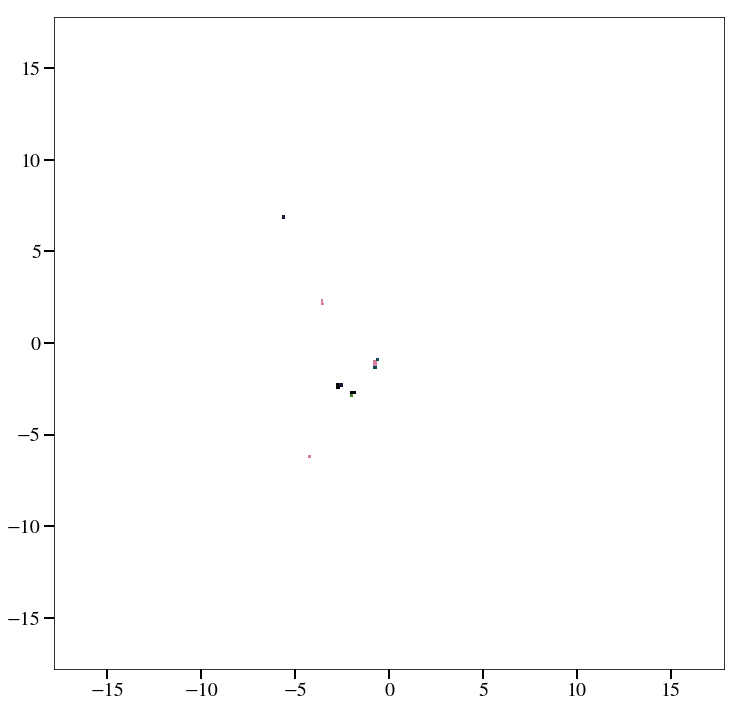

In [35]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_acc['Rx'],
    df_acc['Ry'],
    bins = 256,
    range = 1.5 * r_gal * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

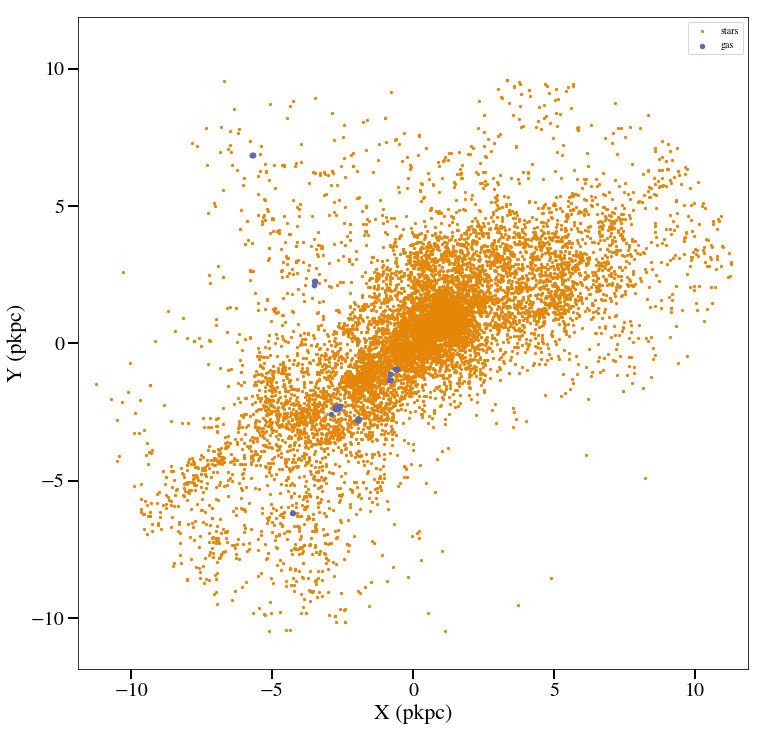

In [46]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.scatter(
    df_acc_star['Rx'],
    df_acc_star['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
    s = 5,
    label = 'stars',
)

ax.scatter(
    df_acc['Rx'],
    df_acc['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 20,
    label = 'gas',
)


ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -1. * r_gal, 1. * r_gal )
ax.set_ylim( -1. * r_gal, 1. * r_gal )

ax.legend()

fig

## Before

### Get Spatial Data

In [37]:
# Format Data
data = {}
for key in [ 'ID', 'Rx', 'Ry', 'Rz' ]:
    data[key] = g_data_prior.get_data( key )
df_prior = pd.DataFrame( data )

# Get rid of duplicates
df_prior = df_prior.drop_duplicates( 'ID', keep=False )

df_prior = df_prior.set_index( 'ID' )

In [38]:
df_acc_prior = df_prior.loc[ids_accreted]

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


### Plot Before

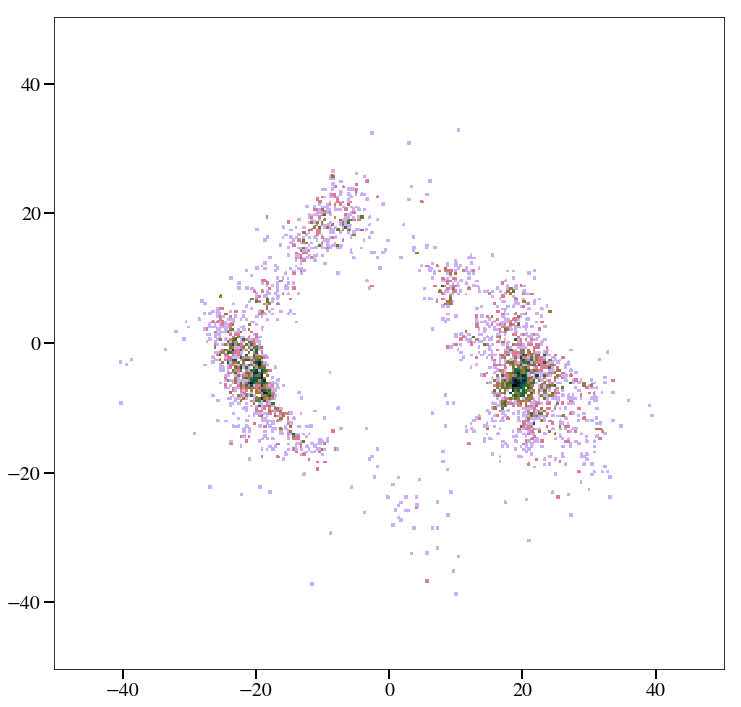

In [39]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    bins = 256,
    range = 0.3 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

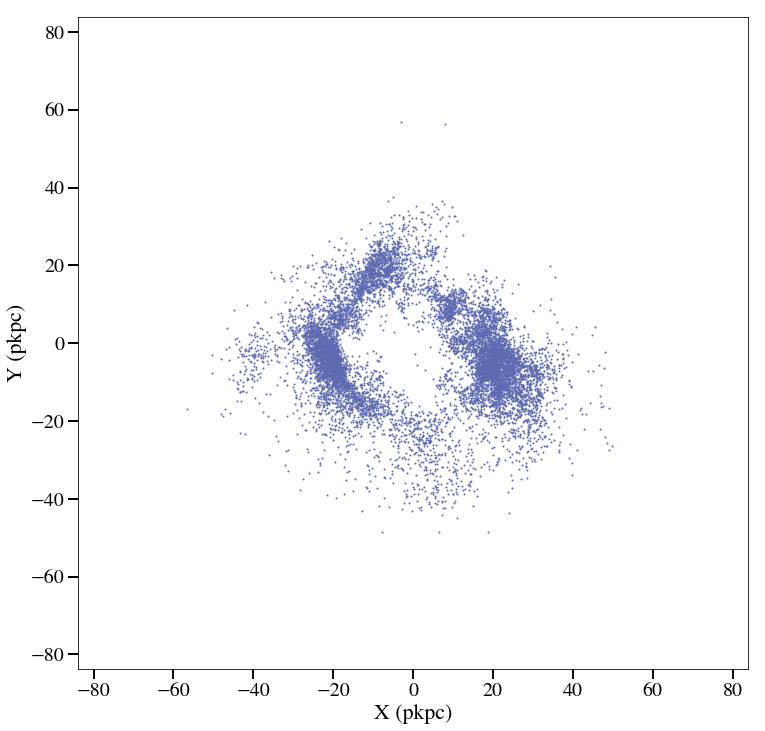

In [40]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.scatter(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 1,
)

ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )
ax.set_ylim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )

fig

# Save Data

In [41]:
file_name = 'ids_full_{}_hothaloacc.hdf5'.format( sim_name )
data_dir = fm.get_linefinder_dir( **sim_kwargs )
file_path = os.path.join( data_dir, file_name )
g = h5py.File( file_path, 'w' )

In [42]:
g.create_dataset( 'target_ids', data=ids_accreted )

<HDF5 dataset "target_ids": shape (10878,), type "<i8">

In [43]:
g.close()